In [1]:
 
!pip install -U tensorflow==2.15 # Keras 2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
  

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras

from keras.utils import  Sequence
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img, to_categorical
#models
#from efficientnet_lite import EfficientNetLiteB0, EfficientNetLiteB1, EfficientNetLiteB3
from tensorflow.keras.applications import EfficientNetB1
#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

import subprocess
from IPython.display import FileLink, display

from sklearn.utils.class_weight import compute_class_weight

from keras import backend as K


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.utils.class_weight import compute_class_weight

tf.__version__, #keras.__version__

# Data Load

In [4]:

imgs = sorted(glob(r'/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/*/*'))
labels = [el.split('/')[5] for el in imgs ]
SIZE = 150 #345 #414
len(imgs), len(labels)

# Visualisation

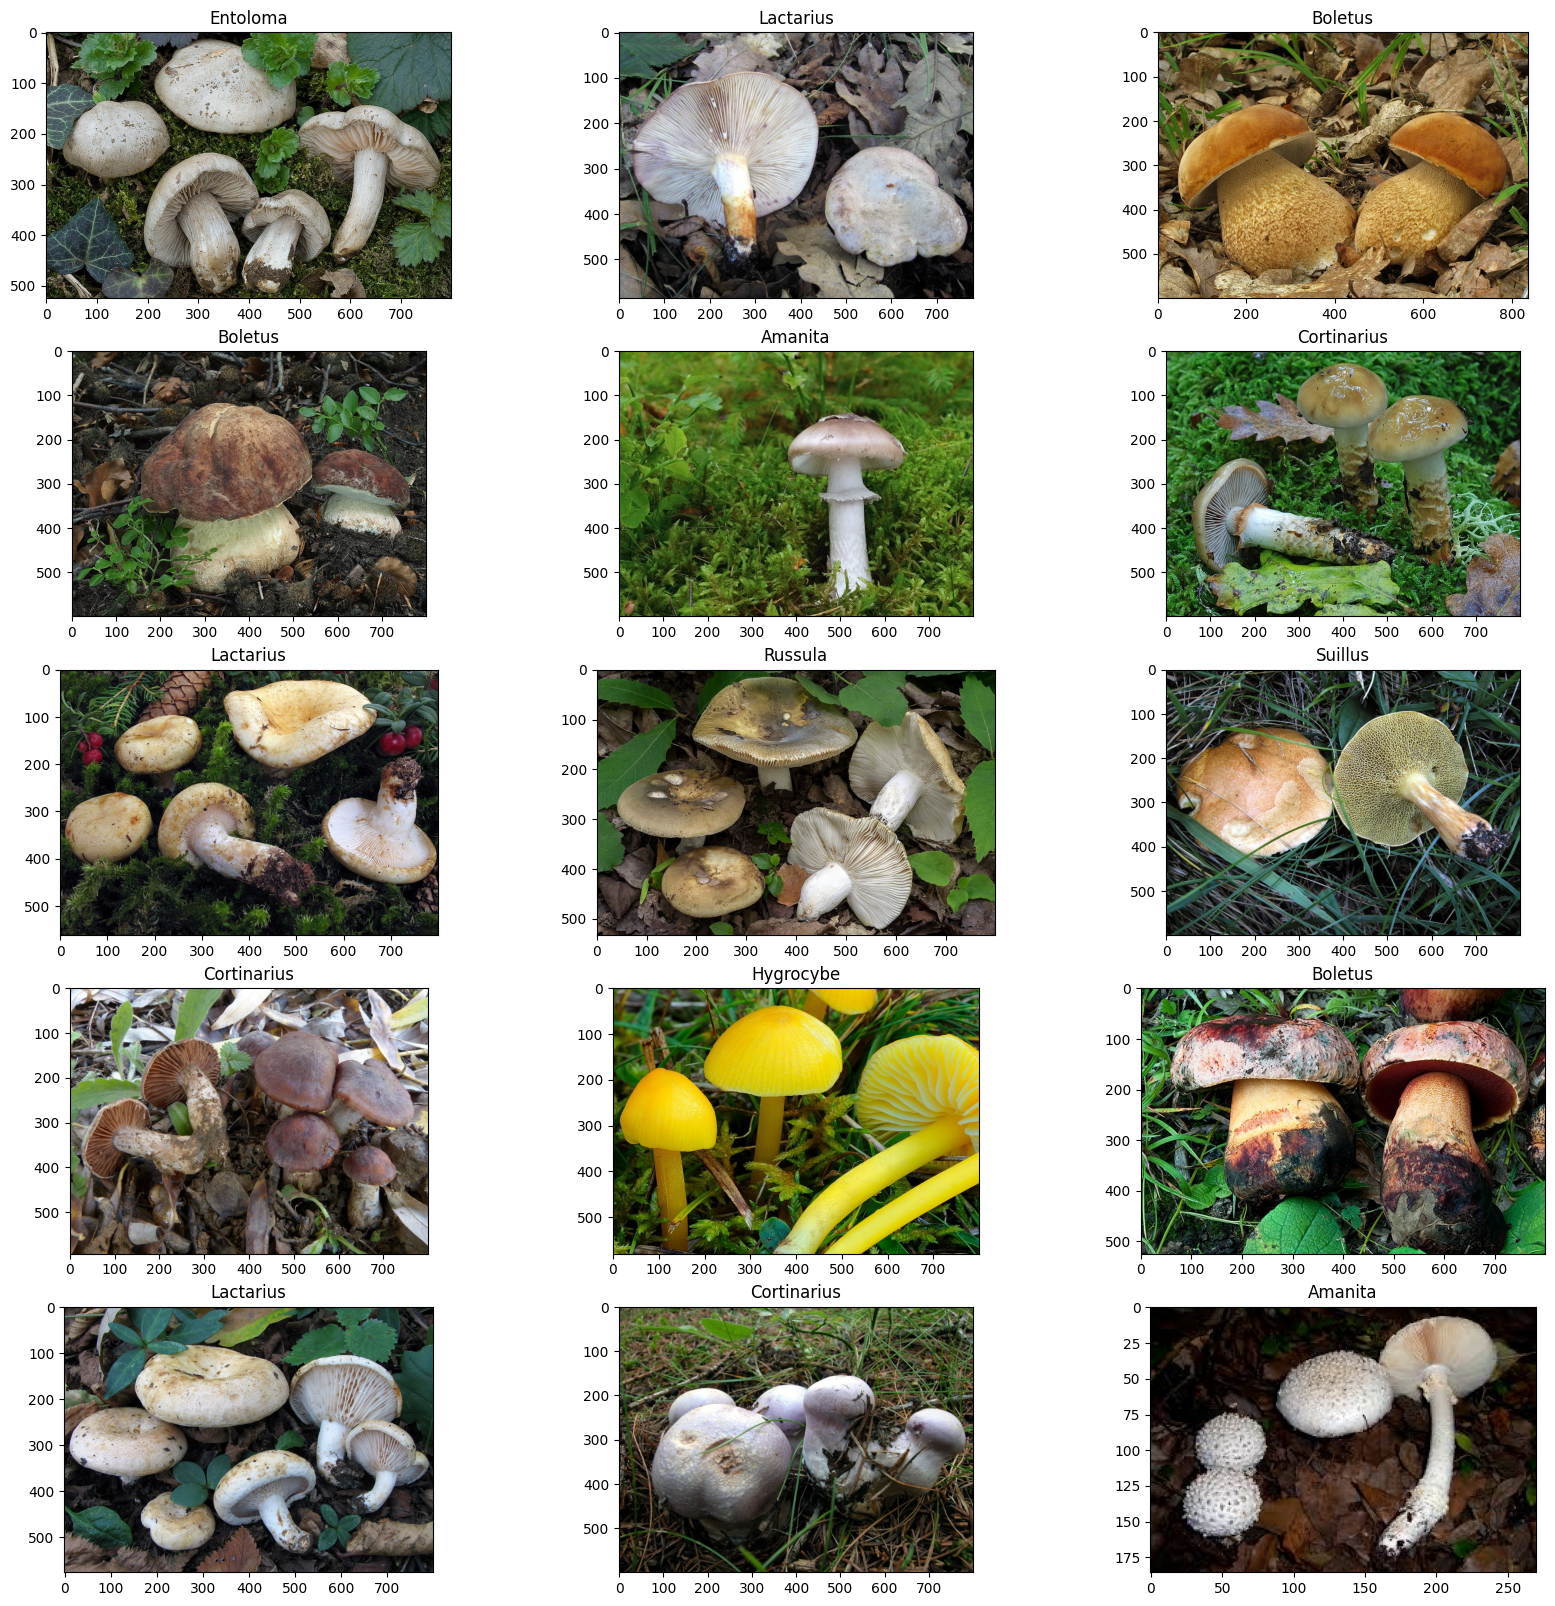

In [6]:

fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )


## Class Distribution

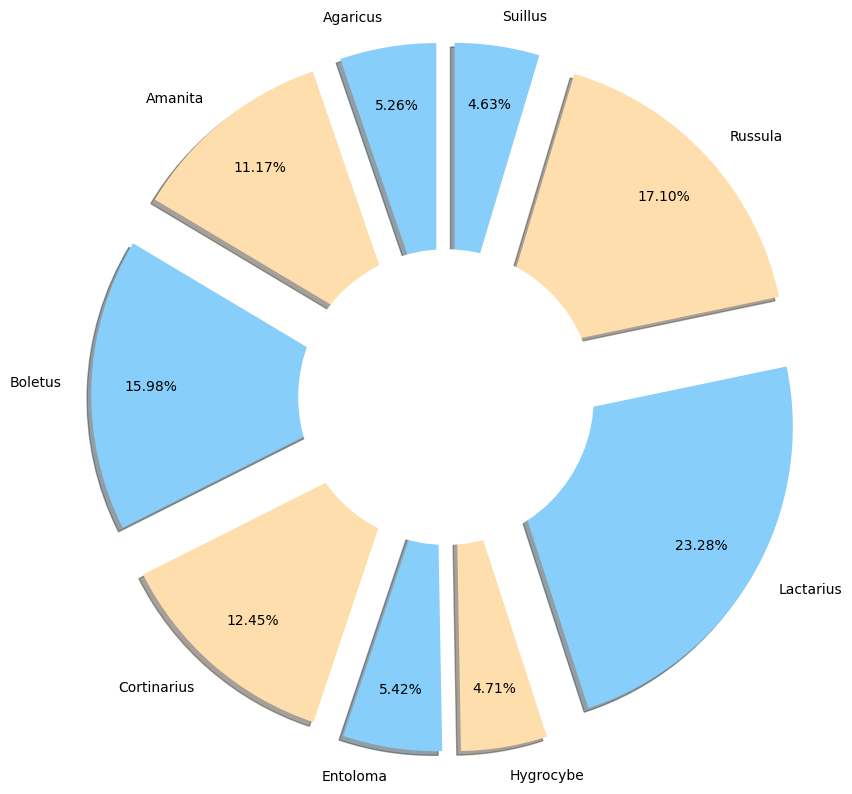

In [7]:

distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
tab = {'lightskyblue': '#87CEFA', 'navajowhite': '#FFDEAD'}

plt.pie.DonutSize=9
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(),radius=2, colors=tab, shadow=True, startangle=90, autopct='%1.2f%%',
       pctdistance=0.80, explode=[0.4 for el in range(9)])

hole = plt.Circle((0, 0), 1.0, facecolor='white')
plt.gcf().gca().add_artist(hole)
 
plt.show()

## Test Train Split

In [27]:
le = LabelEncoder()
la = le.fit_transform(labels)
labels_2 = keras.utils.to_categorical(la, num_classes=9)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=91, stratify=labels)

In [78]:
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

In [79]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        #brightness_range=(1.05, 0.9),
)
valid_gen = ImageDataGenerator(rescale=1./255)

In [33]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, n_classes=9, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        

        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            #Store class
            label = self.labels[i]
            
            batch_labels.append(label)
             
            
        return np.array(batch_imgs), keras.utils.to_categorical(batch_labels, num_classes=self.n_classes)

In [55]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,3),
                 n_classes=9, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = load_img(self.list_IDs[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            # Store sample
            X[i,] =  load_img(ID,target_size=self.dim)
            #X[i,] = tf.image.resize( X[i,], self.dim, method=ResizeMethod.BILINEAR)
            X[i,] =  img_to_array(ID)

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [80]:
training_generator = DataGenerator(X_train, y_train)
validation_generator = DataGenerator(X_test, y_test )


#epoch = 3 # after more than 10 epoch tpu usually shut down 
#history = model.fit(training_generator, validation_data=training_generator, epochs=epoch, callbacks=[early_stop, reduce_lr] )

In [81]:
training_generator = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', shuffle=True) #shuffle=False
validation_generator = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), interpolation='lanczos', )

Found 3357 validated image filenames belonging to 9 classes.
Found 3357 validated image filenames belonging to 9 classes.


# Build up EFB1 model

In [83]:
def build_model(num_classes=9):
    base_model = EfficientNetB1( #B3
        input_shape=(SIZE,SIZE, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet"
    )

    base_model.trainable=True

    return tf.keras.Sequential([
        base_model,
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6), #0.6 0.7
        tf.keras.layers.Dense(210, activation="silu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))
    ])

In [84]:

from sklearn.utils.class_weight import compute_class_weight
cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
def build_model(num_classes=9, shape=(SIZE,SIZE,3), alpha=cls_weight):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(0.5, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB1")
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=2,
        from_logits=False)
    
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [85]:

model = build_model()

## Add weights to categorical crossentropy loss

In [17]:

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [86]:
from sklearn.utils.class_weight import compute_class_weight
cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#loss = weighted_categorical_crossentropy(cls_weight)
loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=cls_weight,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0



In [87]:

epoch = 5 # after more than 10 epoch tpu usually shut down 
history = model.fit(training_generator, validation_data=validation_generator, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/5
105/105 [==============================] - 113s 812ms/step - loss: 2.1956 - accuracy: 0.2505 - val_loss: 1.8091 - val_accuracy: 0.1117 - lr: 0.0010
Epoch 2/5
105/105 [==============================] - 82s 786ms/step - loss: 1.5525 - accuracy: 0.3920 - val_loss: 1.9413 - val_accuracy: 0.0465 - lr: 0.0010
Epoch 3/5
105/105 [==============================] - 82s 787ms/step - loss: 1.1023 - accuracy: 0.5043 - val_loss: 1.7815 - val_accuracy: 0.0527 - lr: 3.0000e-04
Epoch 4/5
105/105 [==============================] - 82s 785ms/step - loss: 0.9406 - accuracy: 0.5684 - val_loss: 1.8256 - val_accuracy: 0.0533 - lr: 3.0000e-04
Epoch 5/5
105/105 [==============================] - 82s 787ms/step - loss: 0.7543 - accuracy: 0.6029 - val_loss: 2.1099 - val_accuracy: 0.0563 - lr: 9.0000e-05


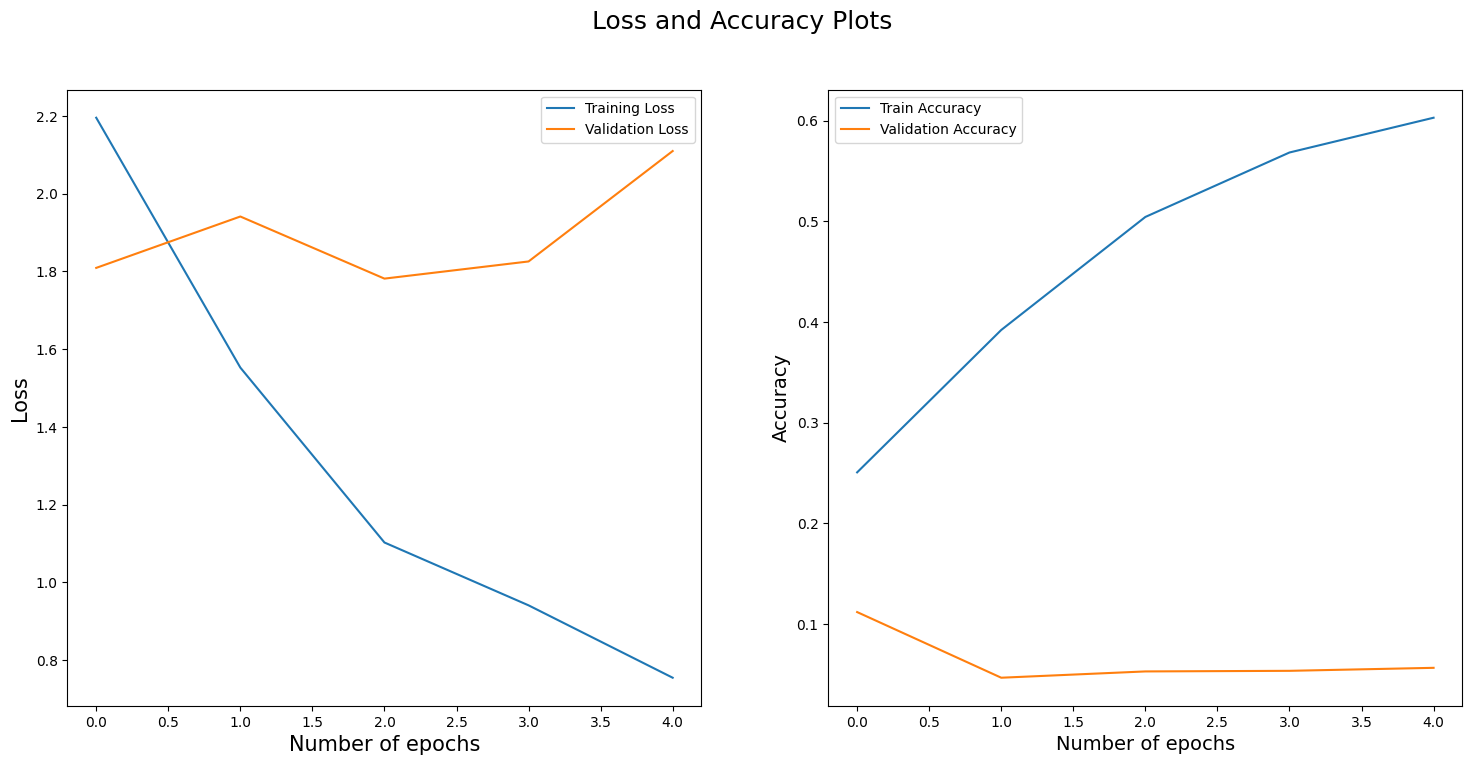

In [88]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)

In [89]:

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes=9)

le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_test = keras.utils.to_categorical(y_test, num_classes=9)


105/105 [==============================] - 39s 357ms/step
              precision    recall  f1-score   support

           0       0.05      0.98      0.10       176
           1       0.00      0.00      0.00       375
           2       0.00      0.00      0.00       536
           3       0.00      0.00      0.00       418
           4       0.00      0.00      0.00       182
           5       0.00      0.00      0.00       158
           6       0.00      0.00      0.00       782
           7       0.00      0.00      0.00       574
           8       0.07      0.02      0.03       156

    accuracy                           0.05      3357
   macro avg       0.01      0.11      0.01      3357
weighted avg       0.01      0.05      0.01      3357



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


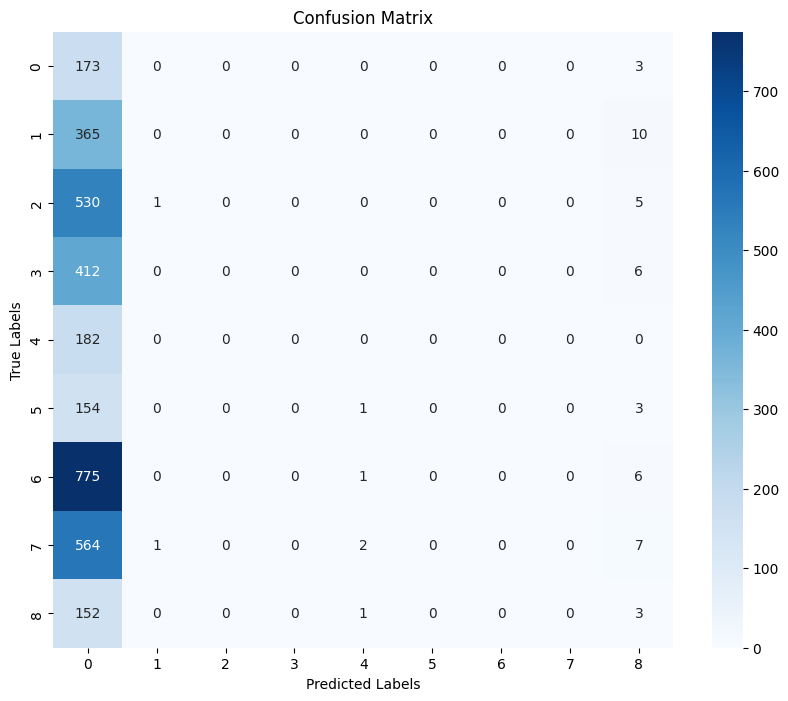

In [90]:


predictions = model.predict(validation_generator, )

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print(classification_report(true_classes, predicted_classes))

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [65]:
len(true_classes) 

3357

In [71]:
len(y_test[:3328]) 

3328

In [68]:
len(y_train) 

3357

In [66]:
len(predicted_classes)

3328

In [59]:




predictions = model.predict(training_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_train, axis=1)

print(classification_report(true_classes, predicted_classes))

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

104/104 [==============================] - 17s 159ms/step


ValueError: Found input variables with inconsistent numbers of samples: [3357, 3328]

In [49]:
predictions.shape

(3328, 9)

In [50]:
len(y_train)

3357

In [ ]:

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes=9)

le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_test = keras.utils.to_categorical(y_test, num_classes=9)

In [39]:
model.save('mushroms_9_efb1_2212_t211_wb.h5')

# Continue training

In [40]:

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.0000e-06) 
model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=0, min_lr=1.0000e-08) #0
epoch = 5
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr] )

Epoch 1/4
147/147 [==============================] - 2103s 14s/step - loss: 1.1855 - accuracy: 0.8723 - val_loss: 1.0521 - val_accuracy: 0.8779 - lr: 1.0000e-06
Epoch 2/4
147/147 [==============================] - 2085s 14s/step - loss: 1.1745 - accuracy: 0.8747 - val_loss: 1.0379 - val_accuracy: 0.8779 - lr: 1.0000e-06
Epoch 3/4
147/147 [==============================] - 2103s 14s/step - loss: 1.1381 - accuracy: 0.8789 - val_loss: 1.0355 - val_accuracy: 0.8784 - lr: 1.0000e-06
Epoch 4/4
147/147 [==============================] - 2080s 14s/step - loss: 1.1521 - accuracy: 0.8653 - val_loss: 1.0356 - val_accuracy: 0.8794 - lr: 1.0000e-06


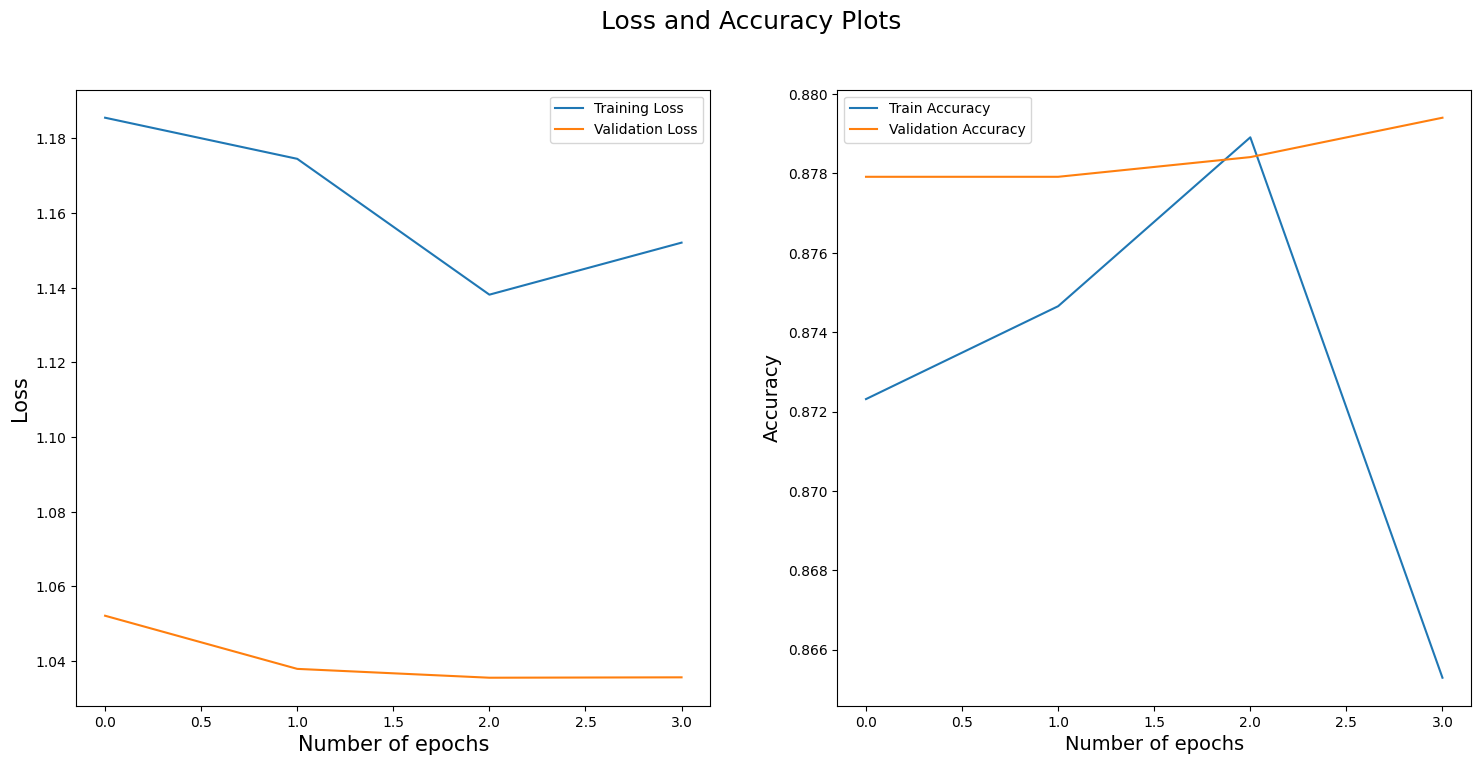

In [41]:
show_history(history)

In [ ]:
model.save('mushroms_9_efb1_2212_2_t211_wb_p2.h5')

In [ ]:
df = pd.DataFrame(list(zip(imgs,labels,)), columns =['X','y'])
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.5, random_state=101, stratify=df['y'])

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=1, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

In [ ]:
def load_and_process_image(image_path, target_size=(300, 300)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return img_array.flatten()

In [ ]:

import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

base_model = EfficientNetB3(include_top=False, weights='imagenet', pooling='avg')

rus = RandomUnderSampler(random_state=42)


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

data_directory = '/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms'
writable_directory = '/kaggle/working/Mushrooms'
validation_directory = '/kaggle/working/validation'
training_directory = '/kaggle/working/training'

# Đếm hình ảnh trong mỗi lớp
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_directory = os.path.join(directory, class_name)
        if os.path.isdir(class_directory):
            class_counts[class_name] = len(os.listdir(class_directory))
    return class_counts

def load_and_process_image(image_path, target_size=(300, 300)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return img_array.flatten()  # Convert to 1D array

# Xóa thư mục writable trước khi sao chép tập tin
if os.path.exists(writable_directory):
    shutil.rmtree(writable_directory)
os.makedirs(writable_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(training_directory, exist_ok=True)

# Sao chép dữ liệu vào thư mục writable 
for class_name in os.listdir(data_directory):
    class_directory = os.path.join(data_directory, class_name)
    writable_class_directory = os.path.join(writable_directory, class_name)
    os.makedirs(writable_class_directory, exist_ok=True)
    
    for image in os.listdir(class_directory):
        src_path = os.path.join(class_directory, image)
        dest_path = os.path.join(writable_class_directory, image)
        shutil.copy(src_path, dest_path)
        
# In số lượng hình ảnh trong mỗi lớp trước khi oversampling
print("Class counts before oversampling:")
class_counts_before = count_images(writable_directory)
for class_name, count in class_counts_before.items():
    print(f"{class_name}: {count}")

# Oversampling
class_counts = class_counts_before
max_count = max(class_counts.values())

X = []
y = []
for class_name, count in class_counts.items():
    class_directory = os.path.join(writable_directory, class_name)
    images = os.listdir(class_directory)

    # Load and process images into numeric arrays


    for image in images:
        image_path = os.path.join(class_directory, image)
        img = load_img(image_path, target_size=(300, 300))
        img_array = img_to_array(img)
        
        X.append(img_array)
        y.append(class_name)

X = np.array(X)
X = base_model.predict(X.reshape(X.shape[0], 300, 300, 3), verbose=0)  # Extract features
y = np.array(y)

# Flatten X to 2D array
num_samples, img_size = X.shape[0], np.prod(X.shape[1:])
X = X.reshape(num_samples, img_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit SMOTE on the current class
X_train, y_train = rus.fit_resample(X_train, y_train)
unique_elements, counts = np.unique(y, return_counts=True)
print(unique_elements)
print(counts)
print(X_train.shape)

input_shape = (300, 300, 3)  # Kích thước đầu vào cho EfficientNetB3
num_classes = len(class_counts_before)  
batch_size = 64  


# Tạo mô hình EfficientNetB3
base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Đóng băng các lớp của mô hình cơ bản

In [ ]:


datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        #brightness_range=(1.05, 0.9),
)
valid_gen = ImageDataGenerator(rescale=1./255)

## Conclusion
accuracy: 0.8953 on val data.  
model - EfficientNetLiteB1  
IMG SIZE - 345  
interpolation - lancos  

Lanczos -  is a sophisticated technique for interpolating digital signals, offering superior image quality compared to simpler methods like nearest neighbor and bilinear interpolation. By effectively preserving detail and minimizing aliasing artifacts, Lanczos resampling is widely used in image and signal processing applications.

To achieve accuracy near 90 % I use lancos for interpolations param. In others attempts for models from EfficientNetLiteB0 to EfficientNetLiteB3 and IMG size from 224 to 400 accuracy didn't secede 82% on val data